In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd
    
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    if target_type in (np.int64, np.int32):
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

    

Score (RMSE): 3.124659776687622


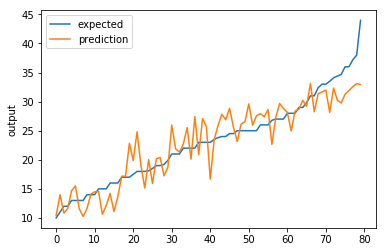

In [2]:
# L1/L2 Regularization

%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

x,y = to_xy(df,'mpg')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model_dir = 'tmp/mpg1'

opt=tf.train.FtrlOptimizer(
    learning_rate=0.01, 
    learning_rate_power=-0.5, 
    initial_accumulator_value=0.1, 
    l1_regularization_strength=1e-5, 
    l2_regularization_strength=1e-5, 
    use_locking=False, 
    name='Ftrl')

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[1])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    optimizer=opt,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50,25,10])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=64,steps=10000)

pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

chart_regression(pred,y_test)



Score (RMSE): 3.6034111976623535


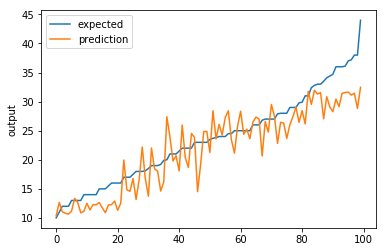

In [3]:
# Dropout

import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

x,y = to_xy(df,'mpg')

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

model_dir = 'tmp/mpg2'

opt=tf.train.MomentumOptimizer(learning_rate=0.00001,momentum=0.9)

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[1])]
regressor = learn.DNNRegressor(
    model_dir= model_dir, 
    optimizer=opt, 
    dropout = 0.2,  
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

chart_regression(pred,y_test)

